# Clustering - Split Dataset by sentence length
**Task**: Take a clustering dataset, split it into multiple datasets based on the length of the sentences and benchmark the performance of a clustering algorithm on each of the datasets.

In [ ]:
%pip install python-dotenv datasets transformers

In [2]:
from dotenv import load_dotenv
if(load_dotenv(".env") == False):
    print("No .env file found")
from datasets import load_dataset
from transformers import AutoModel

# model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True).to('mps')

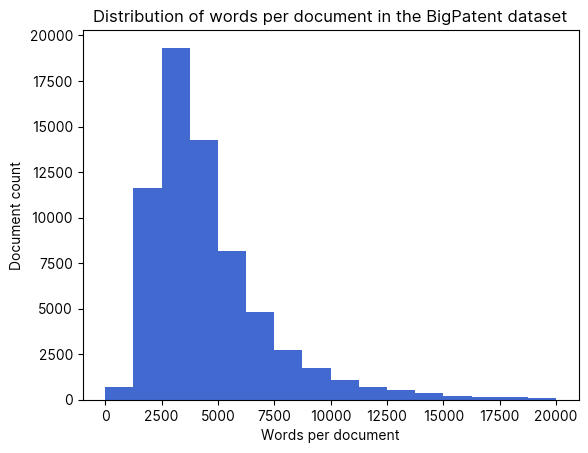

In [7]:
# plot the distribution of word amount per sentence
import matplotlib.pyplot as plt
import numpy as np

word_amounts = [len(sentence.split()) for sentence in dataset["test"]["sentences"][0]]
word_amounts += [len(sentence.split()) for sentence in dataset["test"]["sentences"][1]]
word_amounts += [len(sentence.split()) for sentence in dataset["test"]["sentences"][2]]

plt.rcParams["font.family"] = "Inter"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", [ "#4269D0","#3BA951", "#EFB117", "#FF725C"])


# create a histogram, limit x axis to 20000 and use 16 bins
plt.hist(word_amounts, bins=16, range=(0, 20000))
# label the axes
plt.xlabel('Words per document')
plt.ylabel('Document count')

plt.title('Distribution of words per document in the BigPatent dataset')

plt.savefig('results/clustering/big_patent_distribution.png', dpi=300)


plt.show()

In [3]:
dataset = load_dataset("jinaai/big-patent-clustering")

/Users/malte/miniconda3/envs/embenchmark2/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [16]:
# split dataset into bins of words of max length:
splits = [500, 1000, 2000, 5000, 10000, 20000, 50000, 100000];
# splits = [512, 1024, 2048, 4096, 8192, 16384, 32768, 65536]

binned_clusters = { split: {"sentences": [], "labels": []} for split in splits}


for cluster_set in dataset["test"]:
  for i in range(len(cluster_set["sentences"])):
    sentence = cluster_set["sentences"][i]
    label = cluster_set["labels"][i]
    words = len(sentence.split())
    for split in splits:
      if words <= split:
        binned_clusters[split]["sentences"].append(sentence)
        binned_clusters[split]["labels"].append(label)
        break

/Users/malte/miniconda3/envs/embenchmark2/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [18]:
print(binned_clusters[100000]["sentences"][0])
print(binned_clusters[100000]["labels"][0])

This is a division of application Ser. No. 09/052,095 filed Mar. 31, 1998 (U.S. Pat. No. 6,013,663). 
    
    
     BACKGROUND TO THE INVENTION 
     The present invention relates to a series of new dithiolan derivatives having an excellent ability to enhance the activity of glutathione recluctase. The invention also provides a process for preparing these compounds and methods and compositions using them. 
     Glutathione is found throughout the tissues of the living body, is a major reducing agent in cells, and plays a very important role in the oxidation-reduction metabolic processes. In particular, reduced glutathione (GSH), thanks to the presence of a thiol group, plays a key role in various cellular defence and repair mechanisms. Glutathione peroxidase catalyses the reactions involved in these mechanisms, and is an important enzyme in the antioxidant system, wherein peroxides (e.g. hydrogen peroxide, lipid peroxides and so on) are reduced by GSH. On the other hand, glutathione r

/Users/malte/miniconda3/envs/embenchmark2/lib/python3.9/site-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by mode='default'.
  table = cls._concat_blocks(blocks, axis=0)


25000

In [ ]:
for cluster in binned_clusters:
  print(cluster, len(binned_clusters[cluster]["sentences"]))

In [ ]:
import sys

sys.path.append('/Users/malte/Developer/embenchmark/packages/mteb')

from packages.mteb.mteb.evaluation.evaluators import ClusteringEvaluator
# from mteb import ClusteringEvaluator
import numpy as np


# clustering benchmark
def evaluate(model, sentences, labels, **kwargs):
  v_measures = []

  # if len(sentences) is over 800, split sentences and labels into chunks of 800

  sentence_chunk = sentences[:200]
  label_chunk = labels[:200]

  evaluator = ClusteringEvaluator(sentence_chunk, label_chunk, **kwargs, batch_size=2)
  metrics = evaluator(model)
  v_measures.append(metrics["v_measure"])

  # if len(sentences) > 800:
  #   chunks = [sentences[i:i + 800] for i in range(0, len(sentences), 800)]
  #   labels_chunks = [labels[i:i + 800] for i in range(0, len(labels), 800)]
  #   for i in range(len(chunks)):
  #     evaluator = ClusteringEvaluator(chunks[i], labels_chunks[i], **kwargs)
  #     metrics = evaluator(model)
  #     v_measures.append(metrics["v_measure"])
    




  v_mean = np.mean(v_measures)
  v_std = np.std(v_measures)
  return {"v_measure": v_mean, "v_measure_std": v_std}

In [ ]:
for split in binned_clusters:
  print(f"Split: {split}")
  result = evaluate(model, binned_clusters[split]["sentences"], binned_clusters[split]["labels"])
  print(result)
  # save to file
  with open(f"results_{split}.txt", "w") as file:
    file.write(str(result))

In [8]:
gte_results = {
    "500": {"v_measure": 0.6067810370082493, "v_measure_std": 0.0},
    "1000": {"v_measure": 0.28572342455146044, "v_measure_std": 0.0},
    "2000": {"v_measure": 0.1823522627604808, "v_measure_std": 0.0},
    "5000": {"v_measure": 0.18764073287744037, "v_measure_std": 0.0},
    "10000": {"v_measure": 0.2034702528540851, "v_measure_std": 0.0},
    "20000": {"v_measure": 0.23633937856923057, "v_measure_std": 0.0},
    "50000": {"v_measure": 0.3201021968248694, "v_measure_std": 0.0},
    "100000": {"v_measure": 0.5945001493596176, "v_measure_std": 0.0},
}

jina_results = {
  "500": {'v_measure': 0.6524693142571201, 'v_measure_std': 0.0},
  "1000": {'v_measure': 0.32508328767905376, 'v_measure_std': 0.0},
  "2000": {'v_measure': 0.19271321321780877, 'v_measure_std': 0.0},
  "5000": {'v_measure': 0.20749535908426822, 'v_measure_std': 0.0},
  "10000": {'v_measure': 0.22567938028648946, 'v_measure_std': 0.0},
  "20000": {'v_measure': 0.2801107620757757, 'v_measure_std': 0.0},
  "50000": {'v_measure': 0.3821359336736449, 'v_measure_std': 0.0},
  "100000": {'v_measure': 0.6143560180710919, 'v_measure_std': 0.0}    
}

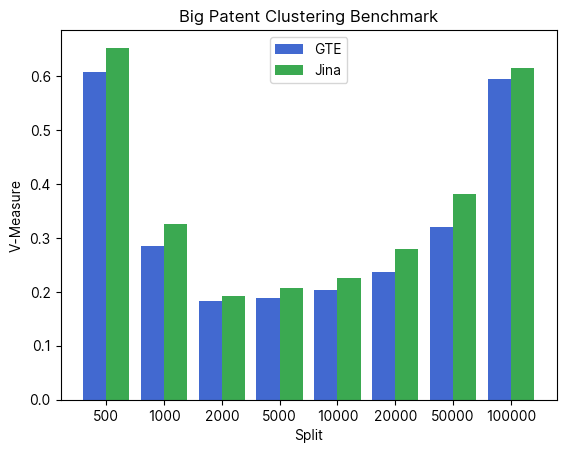

In [9]:
# plot results
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["font.family"] = "Inter"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", [ "#4269D0","#3BA951", "#EFB117", "#FF725C"])

# plot gte and jina results in one plot
fig, ax = plt.subplots()

x = np.arange(len(gte_results))

rects1 = ax.bar(x - 0.2, [gte_results[str(split)]["v_measure"] for split in gte_results], 0.4, label='GTE')
rects2 = ax.bar(x + 0.2, [jina_results[str(split)]["v_measure"] for split in jina_results], 0.4, label='Jina')

ax.set_ylabel('V-Measure')
ax.set_xlabel('Split')

ax.set_xticks(x)
ax.set_xticklabels(gte_results.keys())

# add title
ax.set_title('Big Patent Clustering Benchmark')

ax.legend()
plt.savefig('wiki_cities.png', dpi=300)

plt.show()